In [1]:
import tensorflow as tf

# Initialize TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # Detect TPU
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)  # Define the TPU strategy
    print("Running on TPU:", tpu.master())
except ValueError:
    # Fallback to default CPU/GPU strategy
    strategy = tf.distribute.get_strategy()
    print("Running on CPU/GPU")


Running on CPU/GPU


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-x-ray-dataset-4-categories/Chest X_Ray Dataset/PNEUMONIA/person1180_virus_2010.jpeg
/kaggle/input/chest-x-ray-dataset-4-categories/Chest X_Ray Dataset/PNEUMONIA/person1676_virus_2892.jpeg
/kaggle/input/chest-x-ray-dataset-4-categories/Chest X_Ray Dataset/PNEUMONIA/person1230_virus_2081.jpeg
/kaggle/input/chest-x-ray-dataset-4-categories/Chest X_Ray Dataset/PNEUMONIA/person1513_virus_2632.jpeg
/kaggle/input/chest-x-ray-dataset-4-categories/Chest X_Ray Dataset/PNEUMONIA/person124_virus_238.jpeg
/kaggle/input/chest-x-ray-dataset-4-categories/Chest X_Ray Dataset/PNEUMONIA/person746_virus_1369.jpeg
/kaggle/input/chest-x-ray-dataset-4-categories/Chest X_Ray Dataset/PNEUMONIA/person588_bacteria_2422.jpeg
/kaggle/input/chest-x-ray-dataset-4-categories/Chest X_Ray Dataset/PNEUMONIA/person466_virus_960.jpeg
/kaggle/input/chest-x-ray-dataset-4-categories/Chest X_Ray Dataset/PNEUMONIA/person1590_bacteria_4175.jpeg
/kaggle/input/chest-x-ray-dataset-4-categories/Chest X_Ray Datas

In [3]:
dataset_path = '/kaggle/input/chest-x-ray-dataset-4-categories/Chest X_Ray Dataset/'

In [4]:
image_paths = []
categories = []

categories_list = ['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS']  

for category in categories_list:
    category_path = os.path.join(dataset_path, category)
    
    if os.path.exists(category_path):
        
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            image_paths.append(image_path)
            categories.append(category)

df = pd.DataFrame({'image_path': image_paths, 'category': categories})

In [5]:
df.head()

,image_path,category
0,/kaggle/input/chest-x-ray-dataset-4-categories...,COVID19
1,/kaggle/input/chest-x-ray-dataset-4-categories...,COVID19
2,/kaggle/input/chest-x-ray-dataset-4-categories...,COVID19
3,/kaggle/input/chest-x-ray-dataset-4-categories...,COVID19
4,/kaggle/input/chest-x-ray-dataset-4-categories...,COVID19


In [6]:
df.tail()

,image_path,category
7127,/kaggle/input/chest-x-ray-dataset-4-categories...,TURBERCULOSIS
7128,/kaggle/input/chest-x-ray-dataset-4-categories...,TURBERCULOSIS
7129,/kaggle/input/chest-x-ray-dataset-4-categories...,TURBERCULOSIS
7130,/kaggle/input/chest-x-ray-dataset-4-categories...,TURBERCULOSIS
7131,/kaggle/input/chest-x-ray-dataset-4-categories...,TURBERCULOSIS


In [7]:
df.shape



(7132, 2)

In [8]:
df.columns



Index(['image_path', 'category'], dtype='object')

In [9]:
df.duplicated().sum()

0

In [10]:
df.isnull().sum()



image_path    0
category      0
dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7132 entries, 0 to 7131
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  7132 non-null   object
 1   category    7132 non-null   object
dtypes: object(2)
memory usage: 111.6+ KB


In [12]:
df['category'].unique()



array(['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS'], dtype=object)

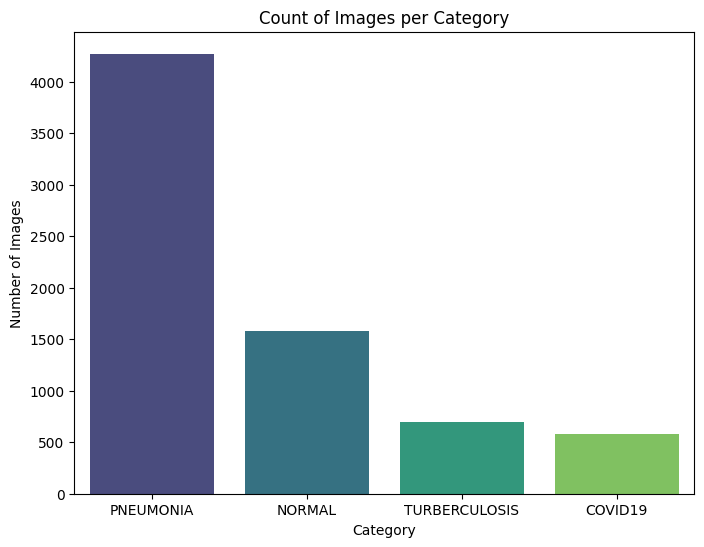

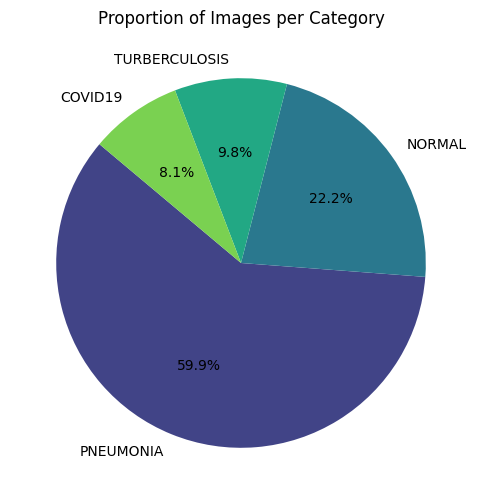

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

category_counts = df['category'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")
plt.title("Count of Images per Category")
plt.xlabel("Category")
plt.ylabel("Number of Images")
plt.show()

plt.figure(figsize=(8, 6))
plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("viridis", len(category_counts)))
plt.title("Proportion of Images per Category")
plt.show()



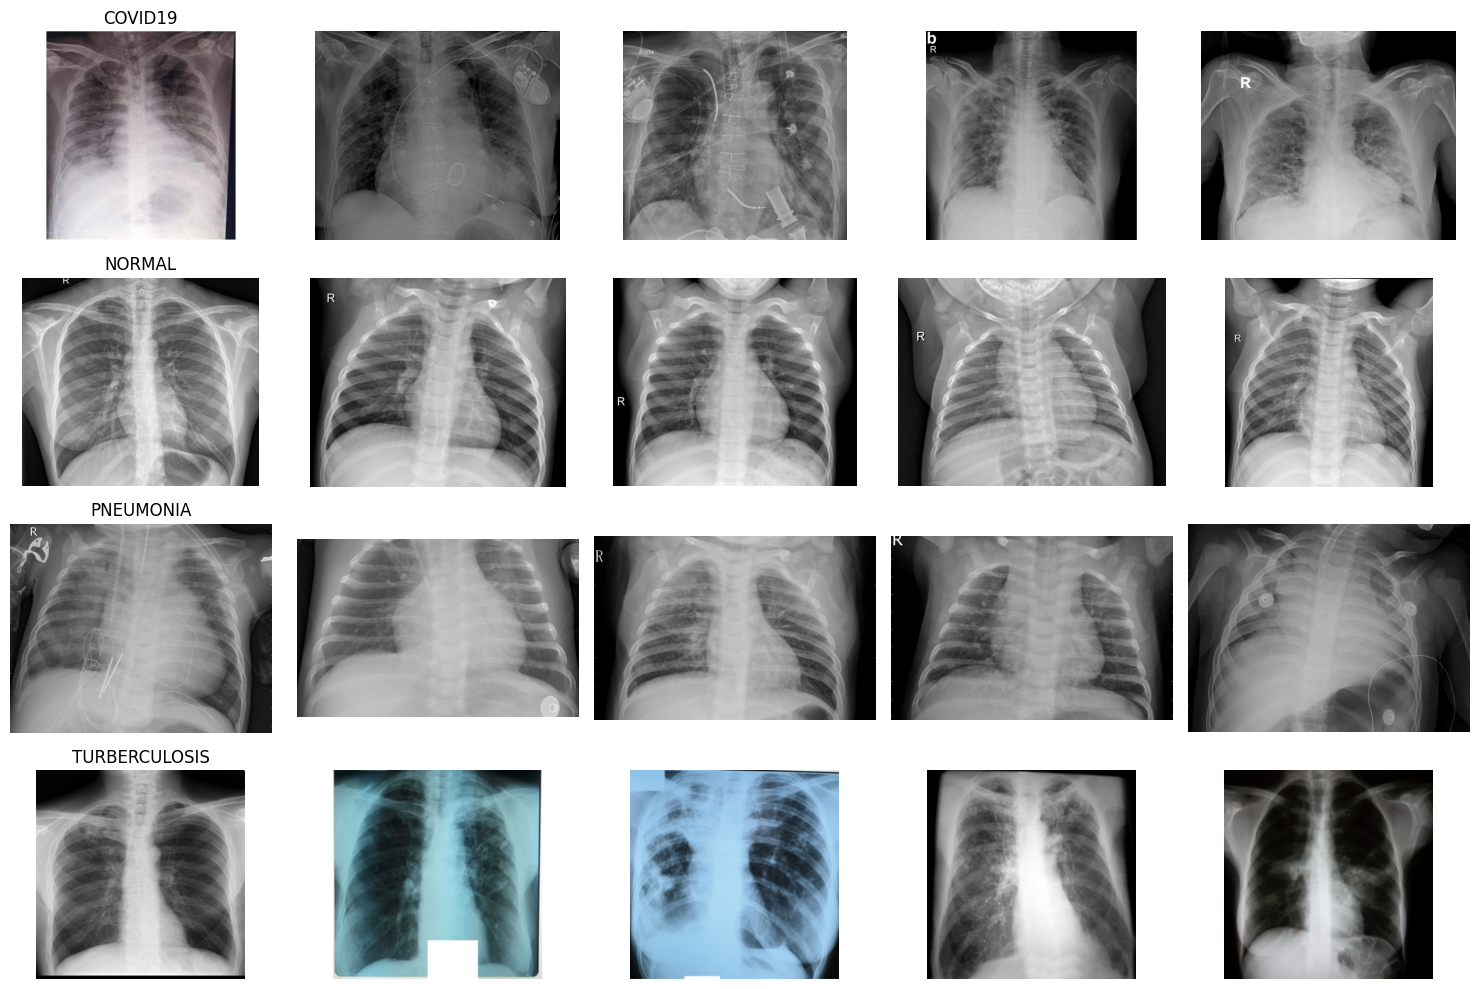

In [14]:
import random
from PIL import Image

num_images_per_category = 5

plt.figure(figsize=(15, 10))

for i, category in enumerate(df['category'].unique()):

    category_images = df[df['category'] == category]['image_path']
    
    selected_images = random.sample(list(category_images), num_images_per_category)
    
    for j, image_path in enumerate(selected_images):

        img = Image.open(image_path)
        
        plt.subplot(len(df['category'].unique()), num_images_per_category, i * num_images_per_category + j + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(category if j == 0 else "") 

plt.tight_layout()
plt.show()



In [15]:
def encoder_block(inputs, num_filters): 

	x = tf.keras.layers.Conv2D(num_filters, 
							3, 
							padding = 'valid')(inputs) 
	x = tf.keras.layers.Activation('relu')(x) 
	
	x = tf.keras.layers.Conv2D(num_filters, 
							3, 
							padding = 'valid')(x) 
	x = tf.keras.layers.Activation('relu')(x) 

	x = tf.keras.layers.MaxPool2D(pool_size = (2, 2), 
								strides = 2)(x) 
	
	return x

In [16]:


from tensorflow.keras.layers import Lambda

def decoder_block(inputs, skip_features, num_filters): 
   
    x = tf.keras.layers.Conv2DTranspose(num_filters, 
                                        (2, 2), 
                                        strides = 2, 
                                        padding = 'valid')(inputs) 
    
   
    x = Lambda(lambda x: tf.image.resize(x, size=(skip_features.shape[1], skip_features.shape[2])))(x)

    x = tf.keras.layers.Concatenate()([x, skip_features]) 
    
    x = tf.keras.layers.Conv2D(num_filters, 3, padding = 'valid')(x) 
    x = tf.keras.layers.Activation('relu')(x) 

    x = tf.keras.layers.Conv2D(num_filters, 3, padding = 'valid')(x) 
    x = tf.keras.layers.Activation('relu')(x) 
    
    return x



In [17]:
import tensorflow as tf 

def unet_model(input_shape = (256, 256, 3), num_classes = 2): 
	inputs = tf.keras.layers.Input(input_shape) 
	
	s1 = encoder_block(inputs, 64) 
	s2 = encoder_block(s1, 128) 
	s3 = encoder_block(s2, 256) 
	s4 = encoder_block(s3, 512) 
	
	b1 = tf.keras.layers.Conv2D(1024, 3, padding = 'valid')(s4) 
	b1 = tf.keras.layers.Activation('relu')(b1) 
	b1 = tf.keras.layers.Conv2D(1024, 3, padding = 'valid')(b1) 
	b1 = tf.keras.layers.Activation('relu')(b1) 
	
	s5 = decoder_block(b1, s4, 512) 
	s6 = decoder_block(s5, s3, 256) 
	s7 = decoder_block(s6, s2, 128) 
	s8 = decoder_block(s7, s1, 64) 
	
	outputs = tf.keras.layers.Conv2D(num_classes, 
									1, 
									padding = 'valid', 
									activation = 'sigmoid')(s8) 
	
	model = tf.keras.models.Model(inputs = inputs, 
								outputs = outputs, 
								name = 'U-Net') 
	return model 

if __name__ == '__main__': 
	model = unet_model(input_shape=(572, 572, 3), num_classes=2) 
	model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 572, 572, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 570, 570, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 570, 570, 64)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 568, 568, 64)   │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 568, 568, 64)   │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 284, 284, 64)   │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 282, 282, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 282, 282, 128)  │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 280, 280, 128)  │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 280, 280, 128)  │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 140, 140, 128)  │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 138, 138, 256)  │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activation) │ (None, 138, 138, 256)  │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 136, 136, 256)  │        590,080 │ activation_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_5 (Activation) │ (None, 136, 136, 256)  │              0 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 68, 68, 256)    │              0 │ activation_5[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 66, 66, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_6 (Activation) │ (None, 66, 66, 512)    │              0 │ conv2d_6[0][0]         │
├──────────────────────

 Total params: 31,031,810 (118.38 MB)

 Trainable params: 31,031,810 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


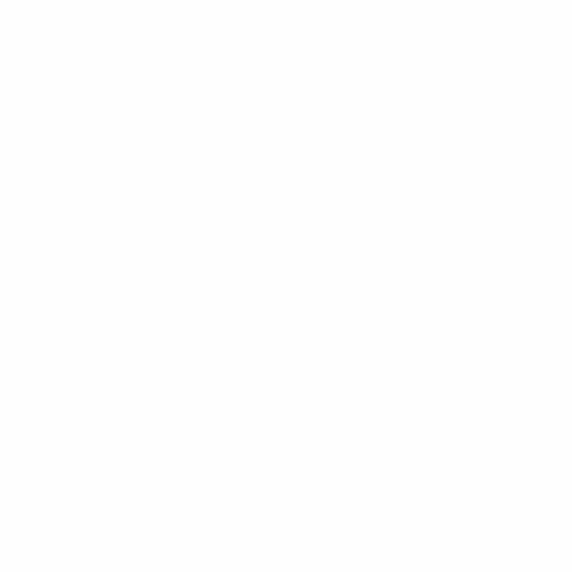

In [18]:
import numpy as np 
from PIL import Image 
from tensorflow.keras.preprocessing import image 
 
img = Image.open('/kaggle/input/chest-x-ray-dataset-4-categories/Chest X_Ray Dataset/COVID19/COVID19(0).jpg')

img = img.convert('RGB')

img = img.resize((572, 572)) 
img_array = image.img_to_array(img) 

img_array = np.expand_dims(img_array, axis=0) 
img_array = img_array / 255.0

model = unet_model(input_shape=(572, 572, 3), num_classes=4)

predictions = model.predict(img_array)

predictions = np.squeeze(predictions, axis=0)
predictions = np.argmax(predictions, axis=-1)

predictions = Image.fromarray(np.uint8(predictions * 255))
predictions = predictions.resize((img.width, img.height))

predictions.save('predicted_image.jpg') 
predictions



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 865ms/step


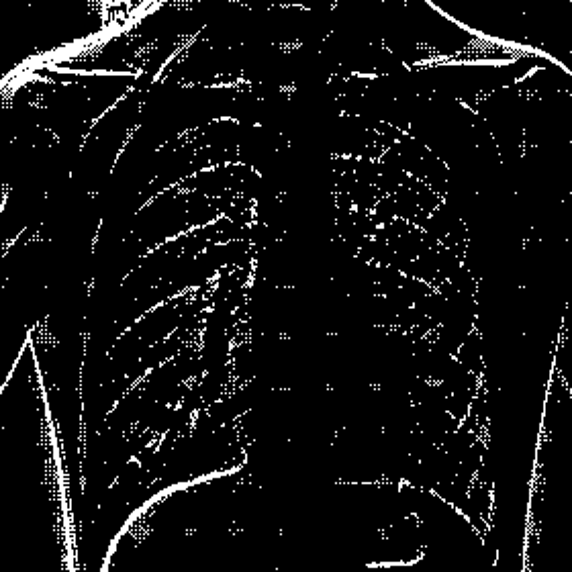

In [19]:
img = Image.open('/kaggle/input/chest-x-ray-dataset-4-categories/Chest X_Ray Dataset/NORMAL/IM-0001-0001.jpeg')

img = img.convert('RGB')

img = img.resize((572, 572)) 
img_array = image.img_to_array(img) 

img_array = np.expand_dims(img_array, axis=0) 
img_array = img_array / 255.0

model = unet_model(input_shape=(572, 572, 3), num_classes=2)

predictions = model.predict(img_array)

predictions = np.squeeze(predictions, axis=0)
predictions = np.argmax(predictions, axis=-1)

predictions = Image.fromarray(np.uint8(predictions * 255))
predictions = predictions.resize((img.width, img.height))

predictions.save('predicted_image.jpg') 
predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step


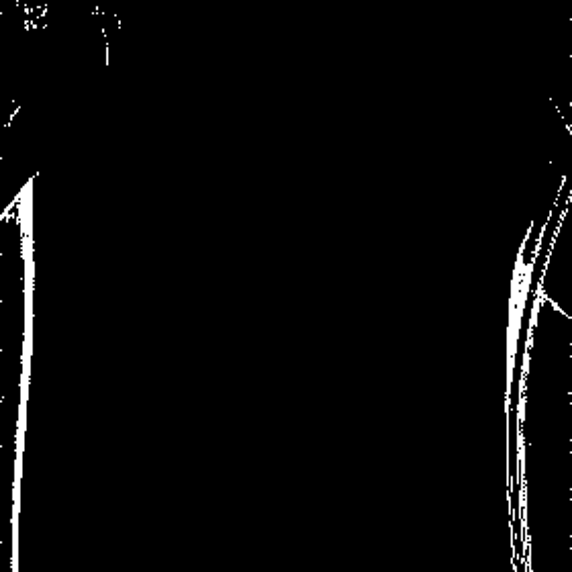

In [20]:
img = Image.open('/kaggle/input/chest-x-ray-dataset-4-categories/Chest X_Ray Dataset/PNEUMONIA/person1000_bacteria_2931.jpeg')

img = img.convert('RGB')

img = img.resize((572, 572)) 
img_array = image.img_to_array(img) 

img_array = np.expand_dims(img_array, axis=0) 
img_array = img_array / 255.0

model = unet_model(input_shape=(572, 572, 3), num_classes=2)

predictions = model.predict(img_array)

predictions = np.squeeze(predictions, axis=0)
predictions = np.argmax(predictions, axis=-1)

predictions = Image.fromarray(np.uint8(predictions * 255))
predictions = predictions.resize((img.width, img.height))

predictions.save('predicted_image.jpg') 
predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step


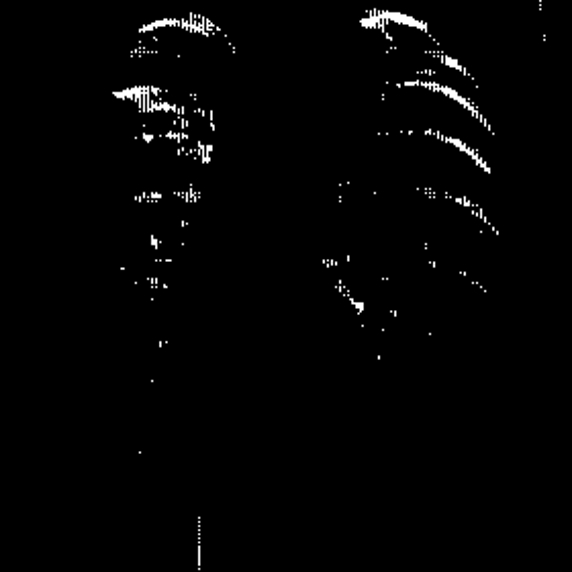

In [21]:
img = Image.open('/kaggle/input/chest-x-ray-dataset-4-categories/Chest X_Ray Dataset/TURBERCULOSIS/Tuberculosis-1.png')

img = img.convert('RGB')

img = img.resize((572, 572)) 
img_array = image.img_to_array(img) 

img_array = np.expand_dims(img_array, axis=0) 
img_array = img_array / 255.0

model = unet_model(input_shape=(572, 572, 3), num_classes=2)

predictions = model.predict(img_array)

predictions = np.squeeze(predictions, axis=0)
predictions = np.argmax(predictions, axis=-1)

predictions = Image.fromarray(np.uint8(predictions * 255))
predictions = predictions.resize((img.width, img.height))

predictions.save('predicted_image.jpg') 
predictions

In [22]:


from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

df['category_encoded'] = label_encoder.fit_transform(df['category'])



In [23]:
df

,image_path,category,category_encoded
0,/kaggle/input/chest-x-ray-dataset-4-categories...,COVID19,0
1,/kaggle/input/chest-x-ray-dataset-4-categories...,COVID19,0
2,/kaggle/input/chest-x-ray-dataset-4-categories...,COVID19,0
3,/kaggle/input/chest-x-ray-dataset-4-categories...,COVID19,0
4,/kaggle/input/chest-x-ray-dataset-4-categories...,COVID19,0
...,...,...,...
7127,/kaggle/input/chest-x-ray-dataset-4-categories...,TURBERCULOSIS,3
7128,/kaggle/input/chest-x-ray-dataset-4-categories...,TURBERCULOSIS,3
7129,/kaggle/input/chest-x-ray-dataset-4-categories...,TURBERCULOSIS,3
7130,/kaggle/input/chest-x-ray-dataset-4-categories...,TURBERCULOSIS,3


In [24]:


df = df[['image_path', 'category_encoded']]



In [25]:
from imblearn.over_sampling import RandomOverSampler

In [26]:


ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df[['image_path']], df['category_encoded'])



In [27]:
df_resampled = pd.DataFrame(X_resampled, columns=['image_path'])
df_resampled['category_encoded'] = y_resampled

In [28]:


print("\nClass distribution after oversampling:")
print(df_resampled['category_encoded'].value_counts())


Class distribution after oversampling:
category_encoded
0    4273
1    4273
2    4273
3    4273
Name: count, dtype: int64


In [29]:
df_resampled

,image_path,category_encoded
0,/kaggle/input/chest-x-ray-dataset-4-categories...,0
1,/kaggle/input/chest-x-ray-dataset-4-categories...,0
2,/kaggle/input/chest-x-ray-dataset-4-categories...,0
3,/kaggle/input/chest-x-ray-dataset-4-categories...,0
4,/kaggle/input/chest-x-ray-dataset-4-categories...,0
...,...,...
17087,/kaggle/input/chest-x-ray-dataset-4-categories...,3
17088,/kaggle/input/chest-x-ray-dataset-4-categories...,3
17089,/kaggle/input/chest-x-ray-dataset-4-categories...,3
17090,/kaggle/input/chest-x-ray-dataset-4-categories...,3


In [30]:


df_resampled['category_encoded'] = df_resampled['category_encoded'].astype(str)



In [31]:


import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image

def unet_model(input_shape=(256, 256, 3), num_classes=2):
    inputs = tf.keras.layers.Input(input_shape) 
    
    s1 = encoder_block(inputs, 64) 
    s2 = encoder_block(s1, 128) 
    s3 = encoder_block(s2, 256) 
    s4 = encoder_block(s3, 512) 
    
    b1 = tf.keras.layers.Conv2D(1024, 3, padding='valid')(s4) 
    b1 = tf.keras.layers.Activation('relu')(b1) 
    b1 = tf.keras.layers.Conv2D(1024, 3, padding='valid')(b1) 
    b1 = tf.keras.layers.Activation('relu')(b1) 
    
    s5 = decoder_block(b1, s4, 512) 
    s6 = decoder_block(s5, s3, 256) 
    s7 = decoder_block(s6, s2, 128) 
    s8 = decoder_block(s7, s1, 64) 
    
    outputs = tf.keras.layers.Conv2D(num_classes, 1, padding='valid', activation='sigmoid')(s8) 
    
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name='U-Net') 
    return model

def create_folders():
    class_names = ['COVID19', 'NORMAL', 'PNEUMONIA', 'TUBERCULOSIS']
    for class_name in class_names:
        class_dir = os.path.join('/kaggle/working/', class_name)
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)

def generate_segmentation_masks(df, model, img_size=(256, 256), num_images_per_class=100):
  
    class_names = ['COVID19', 'NORMAL', 'PNEUMONIA', 'TUBERCULOSIS']
    
    df['category_encoded'] = pd.to_numeric(df['category_encoded'], errors='coerce')
    
    for class_label in range(len(class_names)):
        class_df = df[df['category_encoded'] == class_label].sample(n=num_images_per_class, random_state=42)
        
        for idx, row in class_df.iterrows():
            image_path = row['image_path']
            class_label = row['category_encoded']  
          
            class_name = class_names[class_label]  
            
            img = tf.keras.preprocessing.image.load_img(image_path, target_size=img_size)
            img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
            img_array = tf.expand_dims(img_array, axis=0)  
            
            pred_mask = model.predict(img_array)
            pred_mask = tf.squeeze(pred_mask, axis=0) 
            
            if pred_mask.shape[-1] == 2:
                
                pred_mask = np.argmax(pred_mask, axis=-1)  
            
            pred_mask = (pred_mask > 0.5).astype(np.uint8)
            
            pred_mask = np.expand_dims(pred_mask, axis=-1)
            
            output_dir = f'/kaggle/working/{class_name}'
            os.makedirs(output_dir, exist_ok=True)
            
            mask_image_path = os.path.join(output_dir, f'{os.path.basename(image_path)}_mask.png')
            tf.keras.preprocessing.image.save_img(mask_image_path, pred_mask)
            
            print(f"Saved mask for {image_path} to {mask_image_path}")


model = unet_model(input_shape=(256, 256, 3), num_classes=2) 
generate_segmentation_masks(df_resampled, model)



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Saved mask for /kaggle/input/chest-x-ray-dataset-4-categories/Chest X_Ray Dataset/COVID19/COVID19(240).jpg to /kaggle/working/COVID19/COVID19(240).jpg_mask.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Saved mask for /kaggle/input/chest-x-ray-dataset-4-categories/Chest X_Ray Dataset/COVID19/COVID19(170).jpg to /kaggle/working/COVID19/COVID19(170).jpg_mask.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Saved mask for /kaggle/input/chest-x-ray-dataset-4-categories/Chest X_Ray Dataset/COVID19/COVID19(395).jpg to /kaggle/working/COVID19/COVID19(395).jpg_mask.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Saved mask for /kaggle/input/chest-x-ray-dataset-4-categories/Chest X_Ray Dataset/COVID19/COVID19(4).jpg to /kaggle/working/COVID19/COVID19(4).jpg_mask.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Saved mask for /kaggle/input/chest-x-ray-dataset-4-categories/Chest X_Ray Dataset/COVID19/COVID19(200).jpg to /kaggle/working/COVID19/COVID19(200).jpg_mask.png
1/1 ━━━━━━━━━━━━

In [32]:
df_resampled



,image_path,category_encoded
0,/kaggle/input/chest-x-ray-dataset-4-categories...,0
1,/kaggle/input/chest-x-ray-dataset-4-categories...,0
2,/kaggle/input/chest-x-ray-dataset-4-categories...,0
3,/kaggle/input/chest-x-ray-dataset-4-categories...,0
4,/kaggle/input/chest-x-ray-dataset-4-categories...,0
...,...,...
17087,/kaggle/input/chest-x-ray-dataset-4-categories...,3
17088,/kaggle/input/chest-x-ray-dataset-4-categories...,3
17089,/kaggle/input/chest-x-ray-dataset-4-categories...,3
17090,/kaggle/input/chest-x-ray-dataset-4-categories...,3


In [33]:
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

print ('check')

check


In [34]:
df_resampled['category_encoded'] = df_resampled['category_encoded'].astype(str)

In [35]:


train_df_new, temp_df_new = train_test_split(
    df_resampled,
    train_size=0.8,  
    shuffle=True,
    random_state=42,
    stratify=df_resampled['category_encoded']  
)

valid_df_new, test_df_new = train_test_split(
    temp_df_new,
    test_size=0.5,  
    shuffle=True,
    random_state=42,
    stratify=temp_df_new['category_encoded'] 
)



In [36]:


batch_size = 16
img_size = (256, 256)
channels = 3  
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(rescale=1./255)  
ts_gen = ImageDataGenerator(rescale=1./255)

train_gen_new = tr_gen.flow_from_dataframe(
    train_df_new,
    x_col='image_path',  
    y_col='category_encoded',     
    target_size=img_size,
    class_mode='sparse',  
    color_mode='rgb', 
    shuffle=True,
    batch_size=batch_size
)

valid_gen_new = ts_gen.flow_from_dataframe(
    valid_df_new,
    x_col='image_path',  
    y_col='category_encoded',     
    target_size=img_size,
    class_mode='sparse',  
    color_mode='rgb', 
    shuffle=True,
    batch_size=batch_size
)

test_gen_new = ts_gen.flow_from_dataframe(
    test_df_new,
    x_col='image_path', 
    y_col='category_encoded',    
    target_size=img_size,
    class_mode='sparse',  
    color_mode='rgb', 
    shuffle=False,  
    batch_size=batch_size
)



Found 13673 validated image filenames belonging to 4 classes.
Found 1709 validated image filenames belonging to 4 classes.
Found 1710 validated image filenames belonging to 4 classes.


In [37]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print("Using GPU")
else:
    print("Using CPU")

Using GPU


In [38]:


from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint



In [39]:


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



In [40]:
def unet_classification_model(input_size=(256, 256, 3), num_classes=4):
    inputs = layers.Input(input_size)

    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)

    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)

    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D((2, 2))(conv3)

    bottleneck = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    bottleneck = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(bottleneck)

    upconv3 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bottleneck)
    concat3 = layers.concatenate([upconv3, conv3])
    conv4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(concat3)
    conv4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)

    upconv2 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv4)
    concat2 = layers.concatenate([upconv2, conv2])
    conv5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(concat2)
    conv5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)

    upconv1 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv5)
    concat1 = layers.concatenate([upconv1, conv1])
    conv6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(concat1)
    conv6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)

    gap = layers.GlobalAveragePooling2D()(conv6)  

    output = layers.Dense(num_classes, activation='softmax')(gap)

    model = tf.keras.Model(inputs=inputs, outputs=output)
    return model

model = unet_classification_model(input_size=(256, 256, 3), num_classes=4)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_114 (Conv2D)       │ (None, 256, 256, 64)   │          1,792 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_115 (Conv2D)       │ (None, 256, 256, 64)   │         36,928 │ conv2d_114[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_24          │ (None, 128, 128, 64)   │              0 │ conv2d_115[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_116 (Conv2D)       │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d_24[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_117 (Conv2D)       │ (None, 128, 128, 128)  │        147,584 │ conv2d_116[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_25          │ (None, 64, 64, 128)    │              0 │ conv2d_117[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_118 (Conv2D)       │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_25[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_119 (Conv2D)       │ (None, 64, 64, 256)    │        590,080 │ conv2d_118[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_26          │ (None, 32, 32, 256)    │              0 │ conv2d_119[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_120 (Conv2D)       │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_26[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_121 (Conv2D)       │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_120[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_24       │ (None, 64, 64, 256)    │        524,544 │ conv2d_121[0][0]       │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_24            │ (None, 64, 64, 512)    │              0 │ conv2d_transpose_24[0… │
│ (Concatenate)             │                        │                │ conv2d_119[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_122 (Conv2D)       │ (None, 64, 64, 256)    │      1,179,904 │ concatenate_24[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_123 (Conv2D)       │ (None, 64, 64, 256)    │        590,080 │ conv2d_122[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_25  

 Total params: 7,697,540 (29.36 MB)

 Trainable params: 7,697,540 (29.36 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [42]:
history = model.fit(
    train_gen_new,  
    epochs=5,
    batch_size=16,
    validation_data=valid_gen_new,  
    steps_per_epoch=train_gen_new.samples // train_gen_new.batch_size,
    validation_steps=valid_gen_new.samples // valid_gen_new.batch_size,
    verbose=1
)

Epoch 1/5
854/854 ━━━━━━━━━━━━━━━━━━━━ 313s 332ms/step - accuracy: 0.3892 - loss: 1.2774 - val_accuracy: 0.6073 - val_loss: 0.8685
Epoch 2/5
854/854 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.4375 - loss: 0.8807 - val_accuracy: 0.7692 - val_loss: 0.5629
Epoch 3/5
854/854 ━━━━━━━━━━━━━━━━━━━━ 258s 300ms/step - accuracy: 0.6851 - loss: 0.7920 - val_accuracy: 0.7671 - val_loss: 0.6157
Epoch 4/5
854/854 ━━━━━━━━━━━━━━━━━━━━ 0s 108us/step - accuracy: 0.8750 - loss: 0.2876 - val_accuracy: 0.8462 - val_loss: 0.7410
Epoch 5/5
854/854 ━━━━━━━━━━━━━━━━━━━━ 257s 298ms/step - accuracy: 0.7605 - loss: 0.6182 - val_accuracy: 0.8025 - val_loss: 0.4949


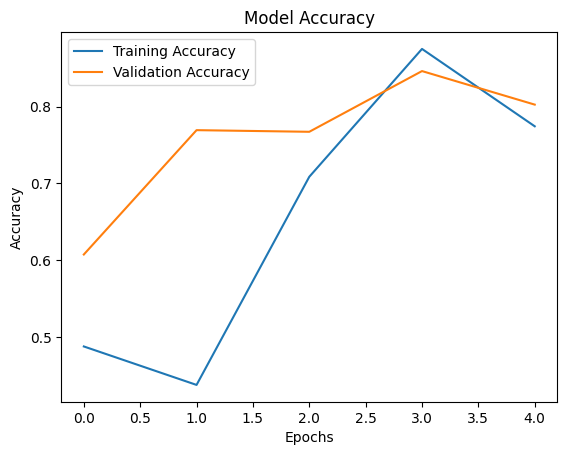

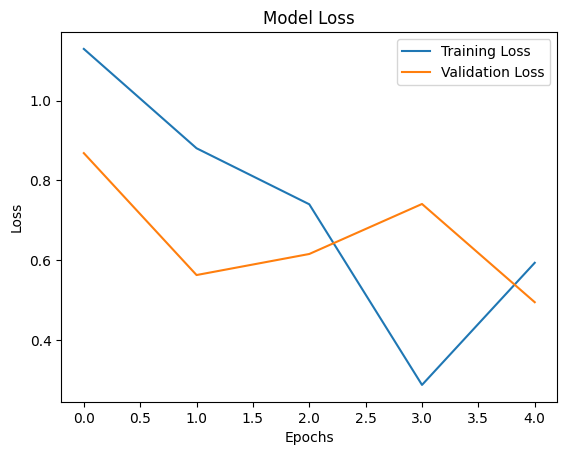

In [43]:


plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.show()



In [44]:


y_pred_probs = model.predict(test_gen_new)
y_pred = np.argmax(y_pred_probs, axis=1) 



107/107 ━━━━━━━━━━━━━━━━━━━━ 33s 301ms/step


In [45]:
y_true = test_gen_new.classes

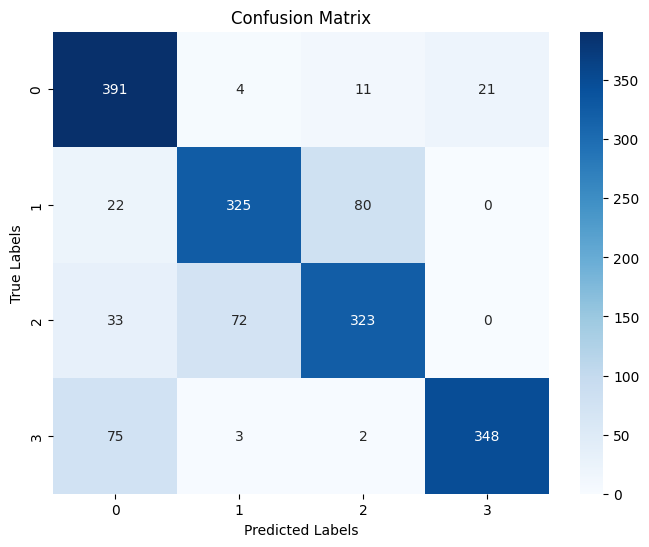

In [46]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_gen_new.class_indices.keys(), yticklabels=test_gen_new.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [47]:


from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, target_names=test_gen_new.class_indices.keys())
print("Classification Report:\n", report)



Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.92      0.82       427
           1       0.80      0.76      0.78       427
           2       0.78      0.75      0.77       428
           3       0.94      0.81      0.87       428

    accuracy                           0.81      1710
   macro avg       0.82      0.81      0.81      1710
weighted avg       0.82      0.81      0.81      1710



In [48]:


def attention_gate(x, g, inter_channels):
    """Attention Gate Implementation."""
    theta_x = layers.Conv2D(inter_channels, (1, 1), strides=(1, 1), padding='same')(x)
    phi_g = layers.Conv2D(inter_channels, (1, 1), strides=(1, 1), padding='same')(g)
    add_xg = layers.Add()([theta_x, phi_g])
    relu_xg = layers.Activation('relu')(add_xg)
    psi = layers.Conv2D(1, (1, 1), strides=(1, 1), padding='same')(relu_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    attention = layers.Multiply()([x, sigmoid_xg])
    return attention

def unet_with_attention(input_size=(256, 256, 3), num_classes=4):
    inputs = layers.Input(input_size)

    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)

    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)

    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D((2, 2))(conv3)

    bottleneck = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    bottleneck = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(bottleneck)

    upconv3 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bottleneck)
    attn3 = attention_gate(conv3, upconv3, inter_channels=128)
    concat3 = layers.concatenate([upconv3, attn3])
    conv4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(concat3)
    conv4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)

    upconv2 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv4)
    attn2 = attention_gate(conv2, upconv2, inter_channels=64)
    concat2 = layers.concatenate([upconv2, attn2])
    conv5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(concat2)
    conv5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)

    upconv1 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv5)
    attn1 = attention_gate(conv1, upconv1, inter_channels=32)
    concat1 = layers.concatenate([upconv1, attn1])
    conv6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(concat1)
    conv6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)

    gap = layers.GlobalAveragePooling2D()(conv6)  
    output = layers.Dense(num_classes, activation='softmax')(gap)

    model = tf.keras.Model(inputs=inputs, outputs=output)
    return model

model = unet_with_attention(input_size=(256, 256, 3), num_classes=4)
model.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_128 (Conv2D)       │ (None, 256, 256, 64)   │          1,792 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_129 (Conv2D)       │ (None, 256, 256, 64)   │         36,928 │ conv2d_128[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_27          │ (None, 128, 128, 64)   │              0 │ conv2d_129[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_130 (Conv2D)       │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d_27[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_131 (Conv2D)       │ (None, 128, 128, 128)  │        147,584 │ conv2d_130[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_28          │ (None, 64, 64, 128)    │              0 │ conv2d_131[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_132 (Conv2D)       │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_28[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_133 (Conv2D)       │ (None, 64, 64, 256)    │        590,080 │ conv2d_132[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_29          │ (None, 32, 32, 256)    │              0 │ conv2d_133[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_134 (Conv2D)       │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_29[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_135 (Conv2D)       │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_134[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_27       │ (None, 64, 64, 256)    │        524,544 │ conv2d_135[0][0]       │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_136 (Conv2D)       │ (None, 64, 64, 128)    │         32,896 │ conv2d_133[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_137 (Conv2D)       │ (None, 64, 64, 128)    │         32,896 │ conv2d_transpose_27[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 64, 64, 128)    │              0 │ conv2d_136[0][0],      │
│                           │                        │                │ conv2d_137[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_108       

 Total params: 7,784,231 (29.69 MB)

 Trainable params: 7,784,231 (29.69 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])



In [50]:
history = model.fit(
    train_gen_new,  
    epochs=5,
    batch_size=16,
    validation_data=valid_gen_new,  
    steps_per_epoch=train_gen_new.samples // train_gen_new.batch_size,
    validation_steps=valid_gen_new.samples // valid_gen_new.batch_size,
    verbose=1
)

Epoch 1/5
854/854 ━━━━━━━━━━━━━━━━━━━━ 301s 338ms/step - accuracy: 0.3787 - loss: 1.2924 - val_accuracy: 0.6539 - val_loss: 0.7062
Epoch 2/5
854/854 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4375 - loss: 0.8642 - val_accuracy: 0.5385 - val_loss: 0.7117
Epoch 3/5
854/854 ━━━━━━━━━━━━━━━━━━━━ 284s 331ms/step - accuracy: 0.7134 - loss: 0.6681 - val_accuracy: 0.8090 - val_loss: 0.4725
Epoch 4/5
854/854 ━━━━━━━━━━━━━━━━━━━━ 0s 118us/step - accuracy: 0.8750 - loss: 0.6166 - val_accuracy: 0.7692 - val_loss: 0.5240
Epoch 5/5
854/854 ━━━━━━━━━━━━━━━━━━━━ 284s 331ms/step - accuracy: 0.8484 - loss: 0.4154 - val_accuracy: 0.8874 - val_loss: 0.3053


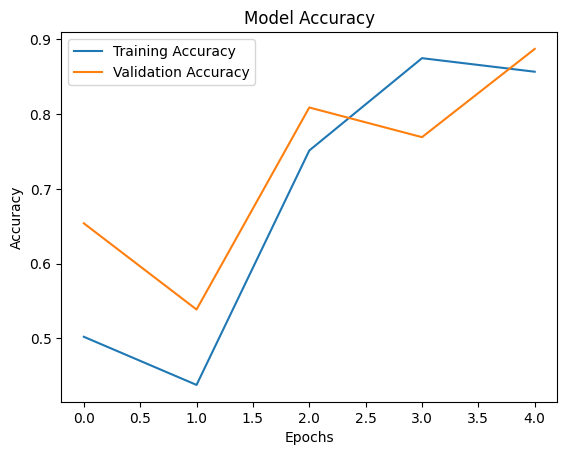

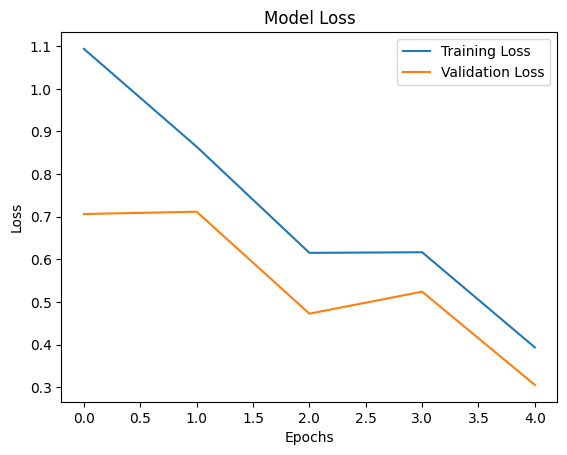

In [51]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

In [52]:


y_pred_probs = model.predict(test_gen_new)
y_pred = np.argmax(y_pred_probs, axis=1) 



107/107 ━━━━━━━━━━━━━━━━━━━━ 25s 225ms/step


In [53]:


y_true = test_gen_new.classes



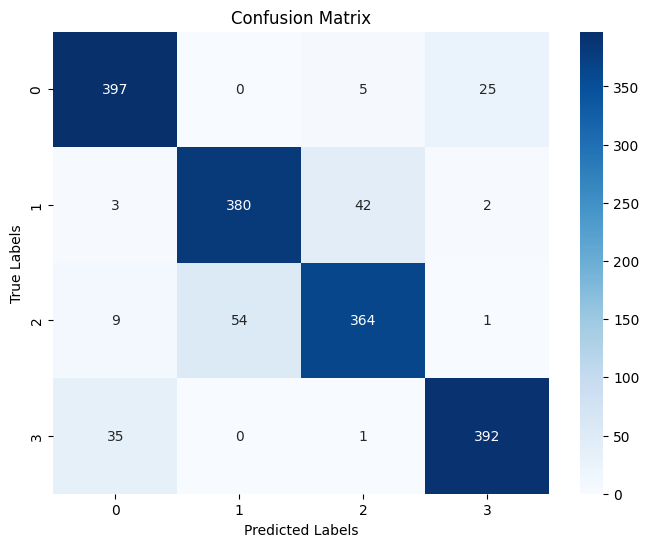

In [54]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_gen_new.class_indices.keys(), yticklabels=test_gen_new.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [55]:


report = classification_report(y_true, y_pred, target_names=test_gen_new.class_indices.keys())
print("Classification Report:\n", report)



Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.93      0.91       427
           1       0.88      0.89      0.88       427
           2       0.88      0.85      0.87       428
           3       0.93      0.92      0.92       428

    accuracy                           0.90      1710
   macro avg       0.90      0.90      0.90      1710
weighted avg       0.90      0.90      0.90      1710

